# What is Dynamic Pricing?

Dynamic Pricing is an application of Data Science that involves adjusting product or service prices based on various factors in real time. It is employed by businesses to optimize their revenue and profitability by setting flexible prices that respond to market demand, customer behaviour, and competitor pricing.

Using data-driven insights and algorithms, businesses can dynamically modify prices to achieve the most favourable outcomes.

For example, consider a ride-sharing company operating in a metropolitan area. The company wants to optimize its pricing strategy to maximize revenue and improve customer satisfaction. The traditional pricing model used by the business is based on fixed rates per kilometre, which does not account for fluctuations in supply and demand.

By implementing a dynamic pricing strategy, the company can leverage data science techniques to analyze various factors such as historical trip data, real-time demand, traffic patterns, and events happening in the area.

Using Machine Learning algorithms, the company can analyze data and adjust its prices in real-time. When demand is high, such as during rush hours or major events, the algorithm can increase the cost of the rides to incentivize more drivers to be available and balance the supply and demand. Conversely, during periods of low demand, the algorithm can lower the prices to attract more customers.

# Dynamic Pricing strategy : Overview

 in a dynamic pricing strategy, the aim is to maximize revenue and profitability by pricing items at the right level that balances supply and demand dynamics. It allows businesses to adjust prices dynamically based on factors like time of day, day of the week, customer segments, inventory levels, seasonal fluctuations, competitor pricing, and market conditions.

To implement a data-driven dynamic pricing strategy, businesses typically require data that can provide insights into customer behaviour, market trends, and other influencing factors. So to create a dynamic pricing strategy, we need to have a dataset based on:

* historical sales data
* customer purchase patterns
* market demand forecasts
* cost data
* customer segmentation data
* and real-time market data.

In [8]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
# reading the file
data = pd.read_csv(r'dynamic_pricing.csv')
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


# Exploratory Data Analysis

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Number_of_Riders,1000.0,60.372000,23.701506,20.000000,40.000000,60.000000,81.000000,100.000000
Number_of_Drivers,1000.0,27.076000,19.068346,5.000000,11.000000,22.000000,38.000000,89.000000
Number_of_Past_Rides,1000.0,50.031000,29.313774,0.000000,25.000000,51.000000,75.000000,100.000000
Average_Ratings,1000.0,4.257220,0.435781,3.500000,3.870000,4.270000,4.632500,5.000000
Expected_Ride_Duration,1000.0,99.588000,49.165450,10.000000,59.750000,102.000000,143.000000,180.000000
Historical_Cost_of_Ride,1000.0,372.502623,187.158756,25.993449,221.365202,362.019426,510.497504,836.116419


### Checking the relationship between the expected ride duration and the historical cost of ride.

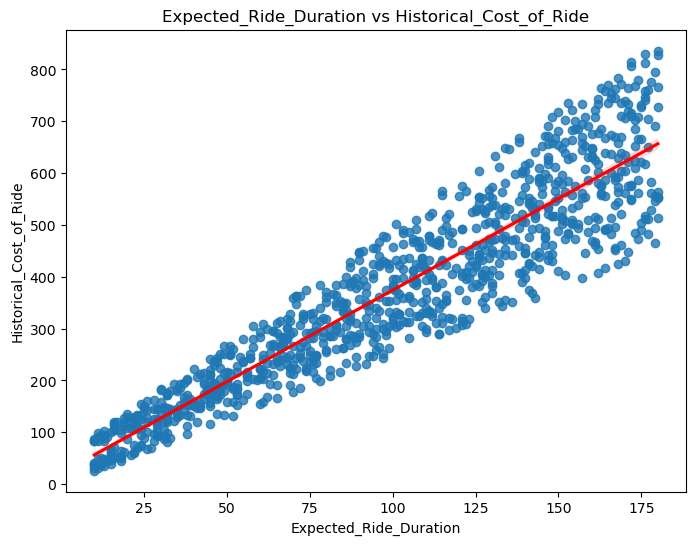

In [40]:
plt.figure(figsize=(8,6))
sns.regplot(data = data, x = 'Expected_Ride_Duration', y = 'Historical_Cost_of_Ride',
            line_kws = {'color':'red'})

plt.title('Expected_Ride_Duration vs Historical_Cost_of_Ride')
plt.show()

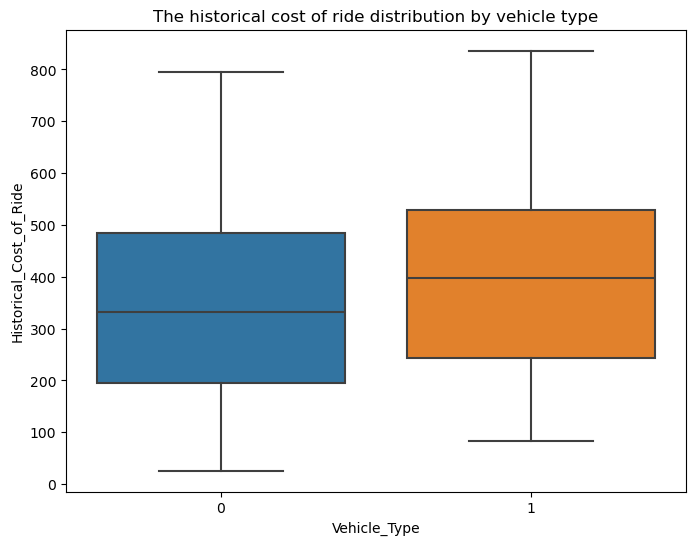

In [42]:
#i will now look at the dostribution of the Historical cost of rides based on the vehicle type.
plt.figure(figsize=(8,6))
sns.boxplot(data = data, x = 'Vehicle_Type', y = 'Historical_Cost_of_Ride') 
plt.title('The historical cost of ride distribution by vehicle type')
plt.show()

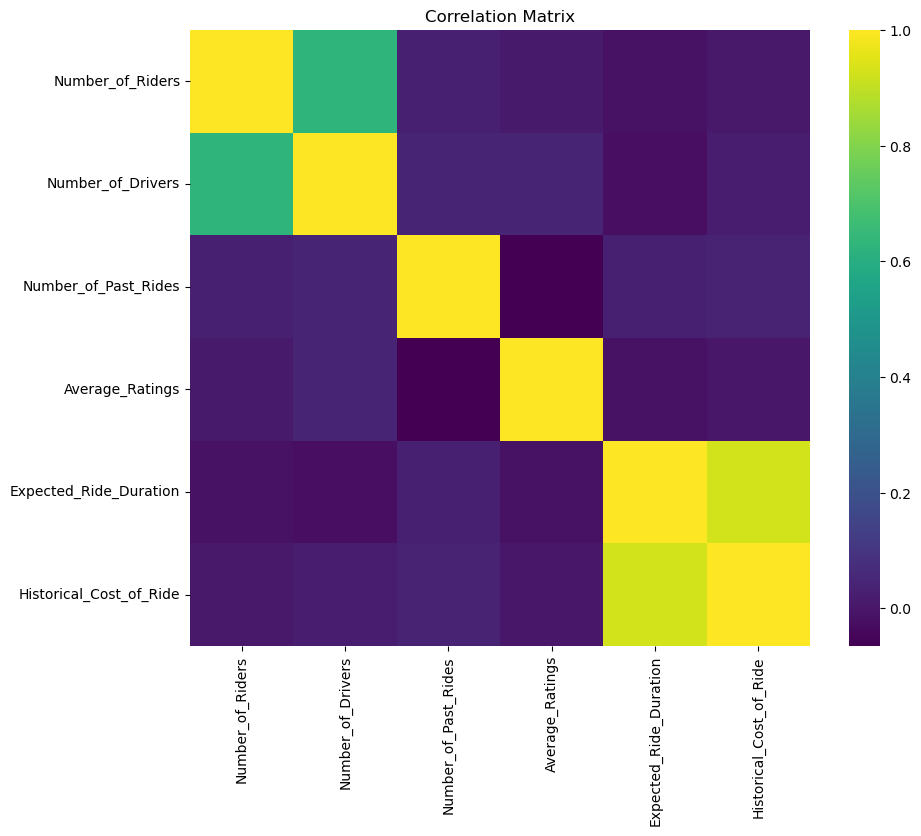

In [26]:
#correlation matrix 
numerical_data = data.select_dtypes(['float64','int64'])
corr_matrix = numerical_data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, fmt= '.2f', cmap = 'viridis', cbar = 'True')
plt.title('Correlation Matrix')
plt.show()

## Implementing a dynamic pricing strategy.

The data provided by the company states that the company uses a pricing model that only takes the expected ride duration as a factor to determine the price for a ride. Now, I will implement a dynamic pricing strategy aiming to adjust the ride costs dynamically based on the demand and supply levels observed in the data. It will capture high-demand periods and low-supply scenarios to increase prices, while low-demand periods and high-supply situations will lead to price reductions.

Here is how to do so:

In [28]:
#calculate the demand multiplier based on the percentile for high and low demand 
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

#calculate the supply multiplier based on percentile for high and low supply. 
high_supply_percentile = 75
low_supply_percentile = 25 

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

#define price adjustment factors for high and low demand/supply 
demand_threshold_high = 1.2 #high demand threshold 
demand_threshold_low = 0.8  #lower demand threshold 
supply_threshold_high = 0.8 #higher supply threshold 
supply_threshold_low = 1.2  #lower supply threshold 

#calculate the adjusted ride cost for dynamic pricing 
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high) 
)

In the above code, I first calculated the demand multiplier by comparing the number of riders to percentiles representing high and low demand levels. If the number of riders exceeds the percentile for high demand, the demand multiplier is set as the number of riders divided by the high-demand percentile. Otherwise, if the number of riders falls below the percentile for low demand, the demand multiplier is set as the number of riders divided by the low-demand percentile.

Next, I calculated the supply multiplier by comparing the number of drivers to percentiles representing high and low supply levels. If the number of drivers exceeds the low-supply percentile, the supply multiplier is set as the high-supply percentile divided by the number of drivers. On the other hand, if the number of drivers is below the low-supply percentile, the supply multiplier is set as the low-supply percentile divided by the number of drivers.

Finally, I calculated the adjusted ride cost for dynamic pricing. It multiplies the historical cost of the ride by the maximum of the demand multiplier and a lower threshold (demand_threshold_low), and also by the maximum of the supply multiplier and an upper threshold (supply_threshold_high). This multiplication ensures that the adjusted ride cost captures the combined effect of demand and supply multipliers, with the thresholds serving as caps or floors to control the price adjustments.

Now I will calculate the percentage profit that I got after implementing this dynamic pricing strategy:

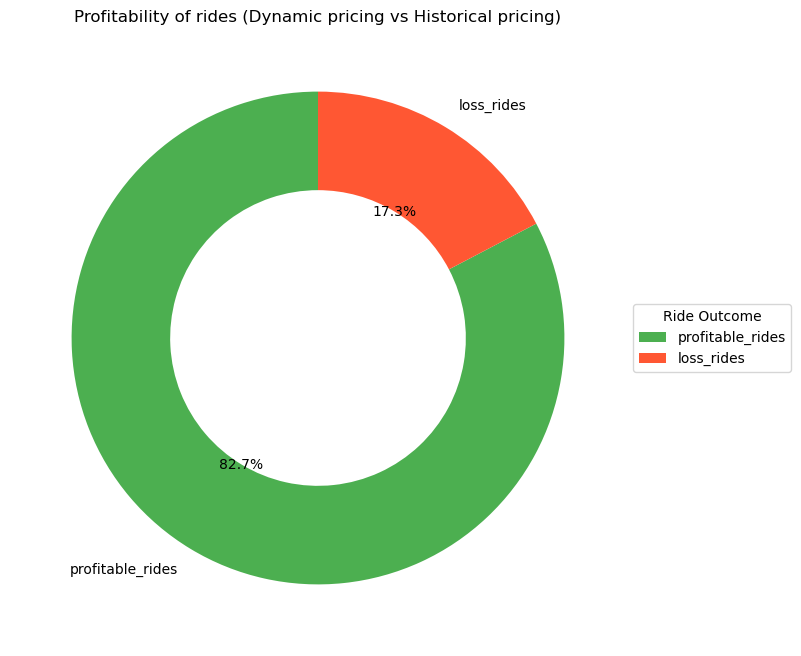

In [31]:
#percentage profit for each ride. 
data['percentage_profit'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100 

#identify the profitable rided where profist percentage is positive 
profitable_rides = data[data['percentage_profit'] > 0] 

#identify the loss rides where percentage profit is negative
loss_rides = data[data['percentage_profit'] < 0] 

#calculate the count of the profitable rides and the loss rides 
profitable_count = len(profitable_rides)
loss_count = len(loss_rides) 

#labels and values to create a donut chart 
labels = ['profitable_rides', 'loss_rides']
values = [profitable_count, loss_count] 

#plotting the donut chart 
plt.figure(figsize=(8,8))

wedges, texts, autotexts = plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, 
        wedgeprops={'width':0.4}, colors = ['#4CAF50', '#FF5733'])

plt.title('Profitability of rides (Dynamic pricing vs Historical pricing)')
plt.legend(wedges, labels, title="Ride Outcome", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

### The relationship between the expected ride duration and the cost of ride based on the dynamic pricing strategy. 

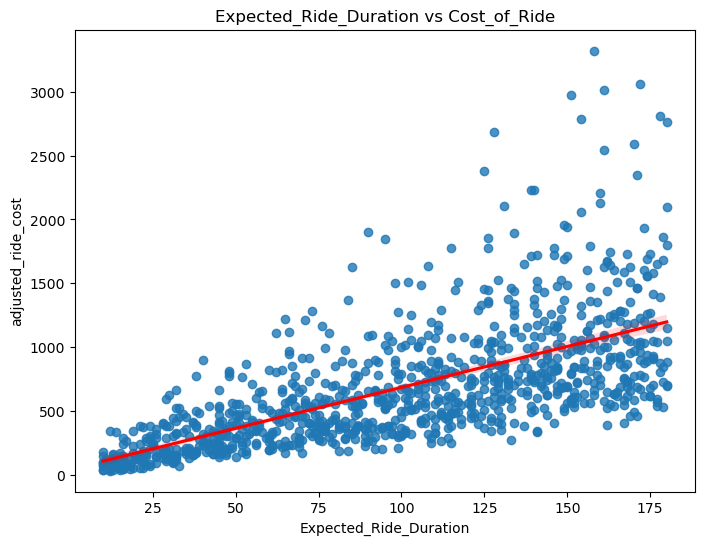

In [43]:
plt.figure(figsize=(8,6))
sns.regplot(data = data, x = 'Expected_Ride_Duration', y = 'adjusted_ride_cost',
            line_kws = {'color':'red'})

plt.title('Expected_Ride_Duration vs Cost_of_Ride')
plt.show()

## Training a predictive model

### Preprocessing

In [33]:
def data_preprocessing_pipeline(data):
    numeric_features = data.select_dtypes(include = ['float', 'int']).columns
    categorical_features = data.select_dtypes(include = ['object']).columns 

    #handling any missing values
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    #detecting and handling any outliers in the numeric features using IQR 
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25) 
        Q3 = data[feature].quatile(0.75) 
        IQR = Q3 - Q1 
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature]) 

    #handling missing values in the categorical features 
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0]) 

    return data

In the above code, I have implemented a data preprocessing pipeline to preprocess the data.

Since vehicle type is a valuable factor, I will convert it into a numerical feature before moving forward

In [34]:
data['Vehicle_Type'] = data['Vehicle_Type'].map({'Premium': 1, 'Economy': 0})

### Splitting the data and training the model

In [35]:
x = np.array(data[['Number_of_Riders', 'Number_of_Drivers', 'Vehicle_Type', 'Expected_Ride_Duration']])
y = np.array(data[['adjusted_ride_cost']])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#reshape to ID array 
y_train = y_train.ravel()
y_test = y_test.ravel() 

#training a random forest regression model 
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

### Testing the model using some input values

In [38]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric
  
# Predicting using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    
    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

# Example prediction using user input values
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = "Economy"
Expected_Ride_Duration = 30
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print("Predicted price:", predicted_price)

Predicted price: [240.44668258]


### A comparison of the actual and predicted results:

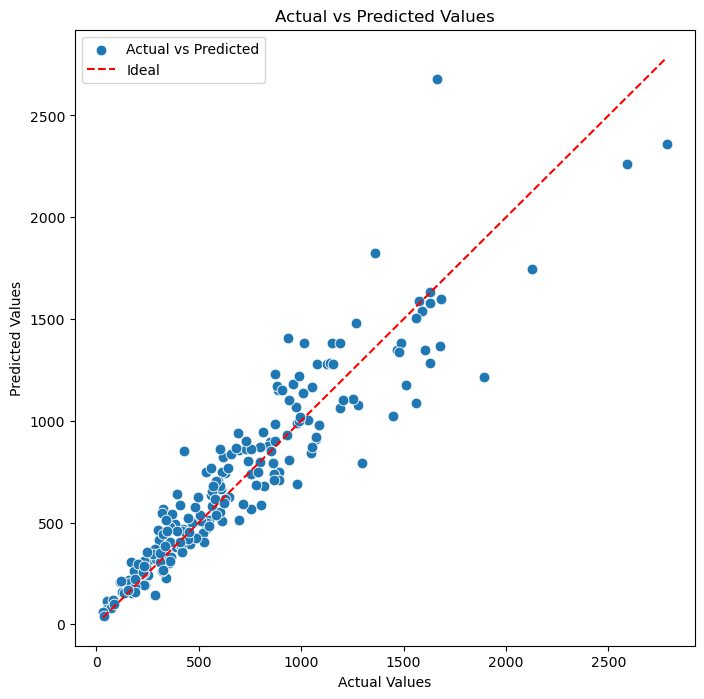

In [39]:
#predicting on the x_test 
y_pred = model.predict(x_test)

plt.figure(figsize=(8,8))

#plotting a scatterplot for actual vs predicted values 
sns.scatterplot(x = y_test.flatten(), y = y_pred, label = 'Actual vs Predicted', s = 60)

#adding the ideal line (y = x)
plt.plot([min(y_test.flatten()), max(y_test.flatten())],
         [min(y_test.flatten()), max(y_test.flatten())],
         color = 'red', linestyle = '--', label = 'Ideal')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')

plt.show()

# Summary

In a dynamic pricing strategy, the aim is to maximize revenue and profitability by pricing items at the right level that balances supply and demand dynamics. It allows businesses to adjust prices dynamically based on factors like time of day, day of the week, customer segments, inventory levels, seasonal fluctuations, competitor pricing, and market conditions.